<a href="https://colab.research.google.com/github/zhulkhoirrifat/nuka-pos/blob/main/TimeSeriesMinimarket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
!pip install keras_tuner

## Import Library

Langkah pertama adalah mengimpor library yang dibutuhkan untuk proses data dan machine learning.

- `pandas` dan `numpy` untuk manipulasi data
- `matplotlib` dan `seaborn` untuk visualisasi
- `sklearn` untuk preprocessing dan model ML


In [71]:
import os
import holidays
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import R2Score, MeanSquaredError, MeanAbsoluteError

## Load dan Persiapan Data

Dataset diambil dari file CSV. Setelah itu, dilakukan pengecekan awal seperti:
- Menampilkan 5 data teratas
- Melihat tipe data dan jumlah missing values
- Menampilkan statistik deskriptif
- Menghapus kolom yang tidak relevan
- Mengubah tipe data jika diperlukan

In [72]:
products_df = pd.read_csv('products.csv')
transactions_df = pd.read_csv('transactions.csv')
transaction_details_df = pd.read_csv('transaction_details.csv')
stores_df = pd.read_csv('stores.csv')

In [73]:
transactions_df = transactions_df.rename(columns={
    'discount': 'discountPerson',
    'status': 'statusTransaction'
})
products_df = products_df.rename(columns={
    'name': 'productName',
    'description': 'descriptionProduct',
    'discount': 'productDiscount'
})
stores_df = stores_df.rename(columns={
    'name': 'storeName',
    'description': 'storeDescription',
    'status': 'storeStatus'
})

In [74]:
transactions_transaction_details_merge = pd.merge(
    transactions_df,
    transaction_details_df,
    on='transactionId',
    how='left'
)

transactions_products_merge = pd.merge(
    transactions_transaction_details_merge,
    products_df,
    on='productId',
    how='left'
)

final_df = pd.merge(
    transactions_products_merge,
    stores_df,
    on='storeId',
    how='left'
)


In [75]:
final_df.columns

Index(['transactionId', 'invoiceId', 'customerId', 'userId', 'storeId',
       'paymentMethodId', 'totalAmount', 'cash', 'change', 'discountPerson',
       'transactionDate', 'statusTransaction', 'transactionDetailId',
       'productId', 'variantId', 'quantity', 'subtotal', 'productCode',
       'serialNumber', 'categoryId', 'productName', 'descriptionProduct',
       'productDiscount', 'basePrice', 'imageUrl', 'isActive', 'StoreCode',
       'tenantId', 'storeName', 'address', 'email', 'image', 'provinceId',
       'cityId', 'districtId', 'villageId', 'storeTypeId', 'postalCode',
       'storeDescription', 'phoneNumber', 'logo', 'permitCertificate',
       'storeStatus'],
      dtype='object')

In [76]:
final_df

,transactionId,invoiceId,customerId,userId,storeId,paymentMethodId,totalAmount,cash,change,discountPerson,...,cityId,districtId,villageId,storeTypeId,postalCode,storeDescription,phoneNumber,logo,permitCertificate,storeStatus
0,1,INV-872171080156,2747.0,62,1,4,200000.00,200433.016175,433.016175,0,...,71,5579,62968,9,35215,Facere eos dignissimos architecto dolor laboru...,628143540196,https://dummyimage.com/638x822,https://picsum.photos/923/384,ACTIVE
1,1,INV-872171080156,2747.0,62,1,4,200000.00,200433.016175,433.016175,0,...,71,5579,62968,9,35215,Facere eos dignissimos architecto dolor laboru...,628143540196,https://dummyimage.com/638x822,https://picsum.photos/923/384,ACTIVE
2,2,INV-763345515943,728.0,93,1,5,200000.00,200976.280882,976.280882,5,...,71,5579,62968,9,35215,Facere eos dignissimos architecto dolor laboru...,628143540196,https://dummyimage.com/638x822,https://picsum.photos/923/384,ACTIVE
3,3,INV-605821091171,870.0,93,1,1,31300.04,31967.037563,666.997563,5,...,71,5579,62968,9,35215,Facere eos dignissimos architecto dolor laboru...,628143540196,https://dummyimage.com/638x822,https://picsum.photos/923/384,ACTIVE
4,4,INV-411881317458,576.0,93,1,4,41220.04,41872.546596,652.506596,10,...,71,5579,62968,9,35215,Facere eos dignissimos architecto dolor laboru...,628143540196,https://dummyimage.com/638x822,https://picsum.photos/923/384,ACTIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
863741,719918,INV-356748409675,NaN,85,30,4,100000.00,100948.727097,948.727097,0,...,71,5579,62968,12,2970,Blanditiis repudiandae eius excepturi. Totam m...,628582519226,https://placekitten.com/78/988,https://placekitten.com/715/72,ACTIVE
863742,719918,INV-356748409675,NaN,85,30,4,100000.00,100948.727097,948.727097,0,...,71,5579,62968,12,2970,Blanditiis repudiandae eius excepturi. Totam m...,628582519226,https://placekitten.com/78/988,https://placekitten.com/715/72,ACTIVE
863743,719919,INV-147944059303,4440.0,141,30,1,100000.00,100327.066901,327.066901,0,...,71,5579,62968,12,2970,Blanditiis repudiandae eius excepturi. Totam m...,628582519226,https://placekitten.com/78/988,https://placekitten.com/715/72,ACTIVE
863744,719920,INV-136116470389,553.0,141,30,7,100000.00,100947.831102,947.831102,0,...,71,5579,62968,12,2970,Blanditiis repudiandae eius excepturi. Totam m...,628582519226,https://placekitten.com/78/988,https://placekitten.com/715/72,ACTIVE


In [77]:
store_type_id = 9
final_df = final_df[final_df['storeTypeId'] == store_type_id]
final_df

,transactionId,invoiceId,customerId,userId,storeId,paymentMethodId,totalAmount,cash,change,discountPerson,...,cityId,districtId,villageId,storeTypeId,postalCode,storeDescription,phoneNumber,logo,permitCertificate,storeStatus
0,1,INV-872171080156,2747.0,62,1,4,200000.00,200433.016175,433.016175,0,...,71,5579,62968,9,35215,Facere eos dignissimos architecto dolor laboru...,628143540196,https://dummyimage.com/638x822,https://picsum.photos/923/384,ACTIVE
1,1,INV-872171080156,2747.0,62,1,4,200000.00,200433.016175,433.016175,0,...,71,5579,62968,9,35215,Facere eos dignissimos architecto dolor laboru...,628143540196,https://dummyimage.com/638x822,https://picsum.photos/923/384,ACTIVE
2,2,INV-763345515943,728.0,93,1,5,200000.00,200976.280882,976.280882,5,...,71,5579,62968,9,35215,Facere eos dignissimos architecto dolor laboru...,628143540196,https://dummyimage.com/638x822,https://picsum.photos/923/384,ACTIVE
3,3,INV-605821091171,870.0,93,1,1,31300.04,31967.037563,666.997563,5,...,71,5579,62968,9,35215,Facere eos dignissimos architecto dolor laboru...,628143540196,https://dummyimage.com/638x822,https://picsum.photos/923/384,ACTIVE
4,4,INV-411881317458,576.0,93,1,4,41220.04,41872.546596,652.506596,10,...,71,5579,62968,9,35215,Facere eos dignissimos architecto dolor laboru...,628143540196,https://dummyimage.com/638x822,https://picsum.photos/923/384,ACTIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696713,580670,INV-618957216769,3425.0,71,24,6,200000.00,200942.496577,942.496577,0,...,71,5783,61365,9,89002,Assumenda quibusdam doloremque voluptatum magn...,628598186962,https://dummyimage.com/732x678,https://placekitten.com/166/111,ACTIVE
696714,580671,INV-934649411840,6616.0,102,24,7,12015.36,12933.187235,917.827235,0,...,71,5783,61365,9,89002,Assumenda quibusdam doloremque voluptatum magn...,628598186962,https://dummyimage.com/732x678,https://placekitten.com/166/111,ACTIVE
696715,580672,INV-741774065882,1856.0,71,24,7,33992.00,34685.163886,693.163886,0,...,71,5783,61365,9,89002,Assumenda quibusdam doloremque voluptatum magn...,628598186962,https://dummyimage.com/732x678,https://placekitten.com/166/111,ACTIVE
696716,580673,INV-266004092044,2934.0,71,24,5,13851.04,14331.565070,480.525070,0,...,71,5783,61365,9,89002,Assumenda quibusdam doloremque voluptatum magn...,628598186962,https://dummyimage.com/732x678,https://placekitten.com/166/111,ACTIVE


In [78]:
final_df['storeId'].value_counts()

,count
storeId,
24,49833
2,23558
1,11279


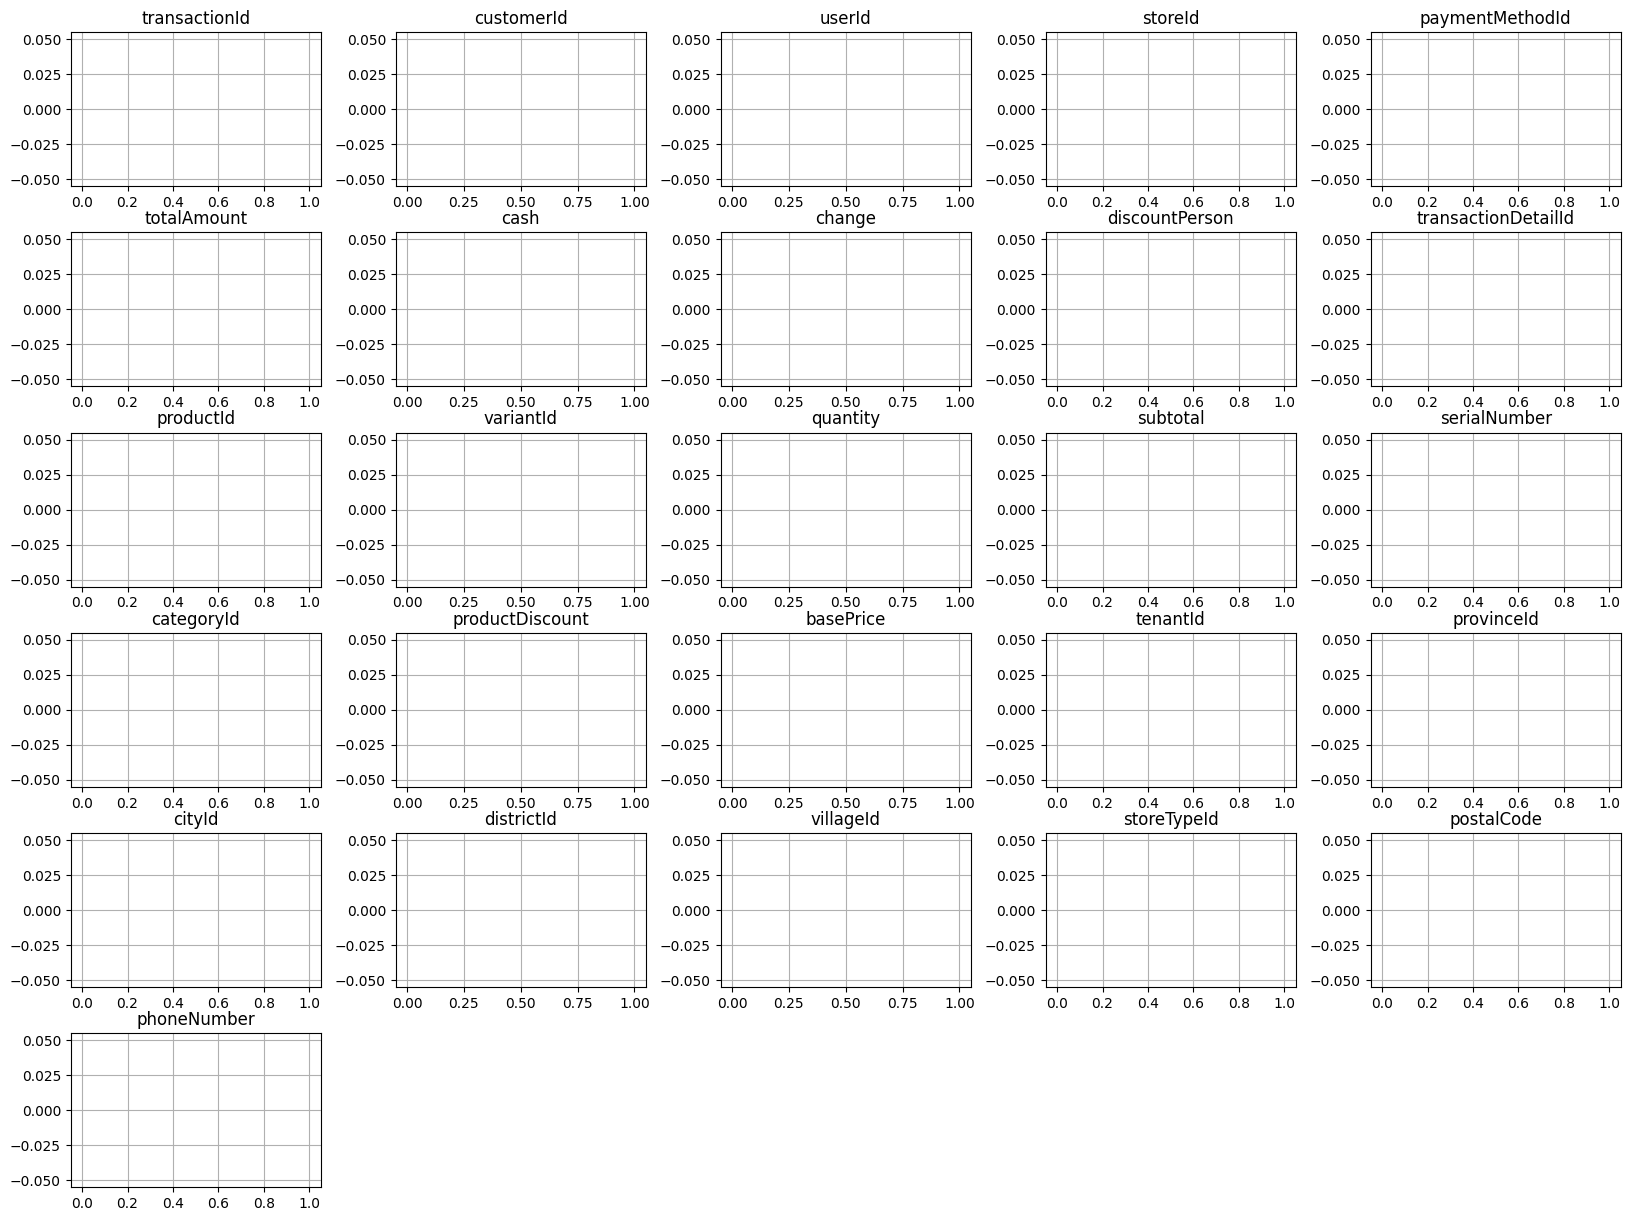

In [80]:
checked = final_df[final_df['storeId'] == 9]

checked.hist(bins=50, figsize=(20, 15))
plt.show()

In [15]:
final_df = final_df[final_df['storeId'] == 9]

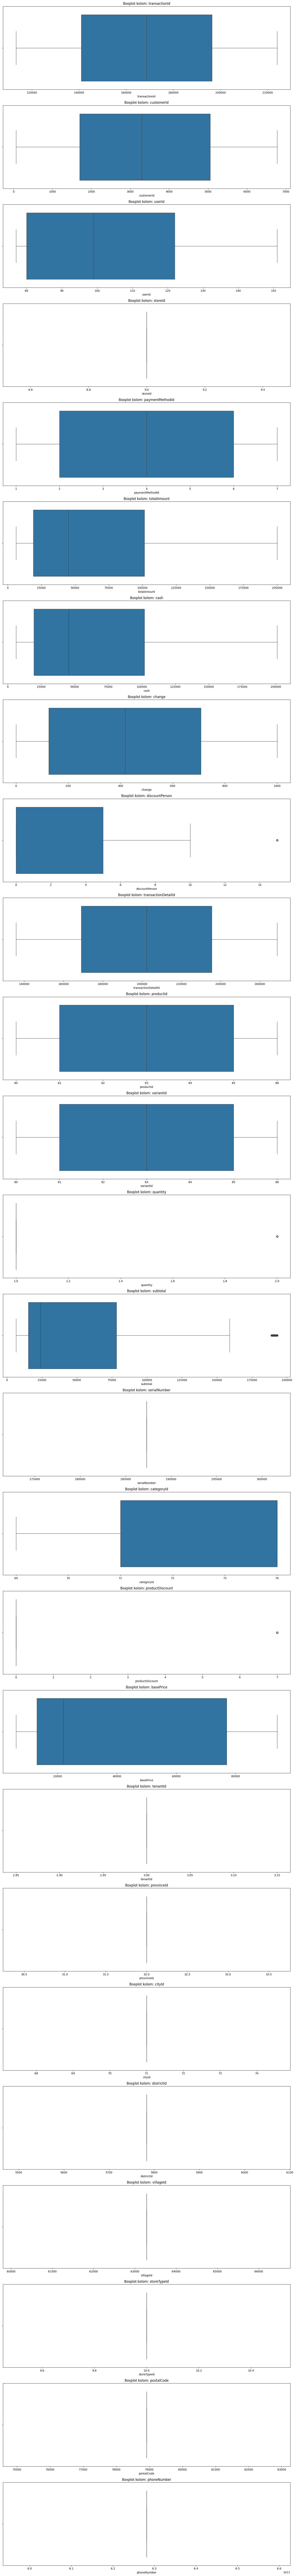

In [16]:
numeric_columns = final_df.select_dtypes(include='number').columns

plt.figure(figsize=(15, 5 * len(numeric_columns)))

for index, column in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns), 1, index)
    sns.boxplot(x=final_df[column])
    plt.title(f'Boxplot kolom: {column}')
    plt.tight_layout()

plt.show()

In [17]:
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data < lower_bound) | (data > upper_bound)

outliers = detect_outliers_iqr(final_df['totalAmount'])

print(f"Number of outliers detected: {sum(outliers)}")

Number of outliers detected: 0


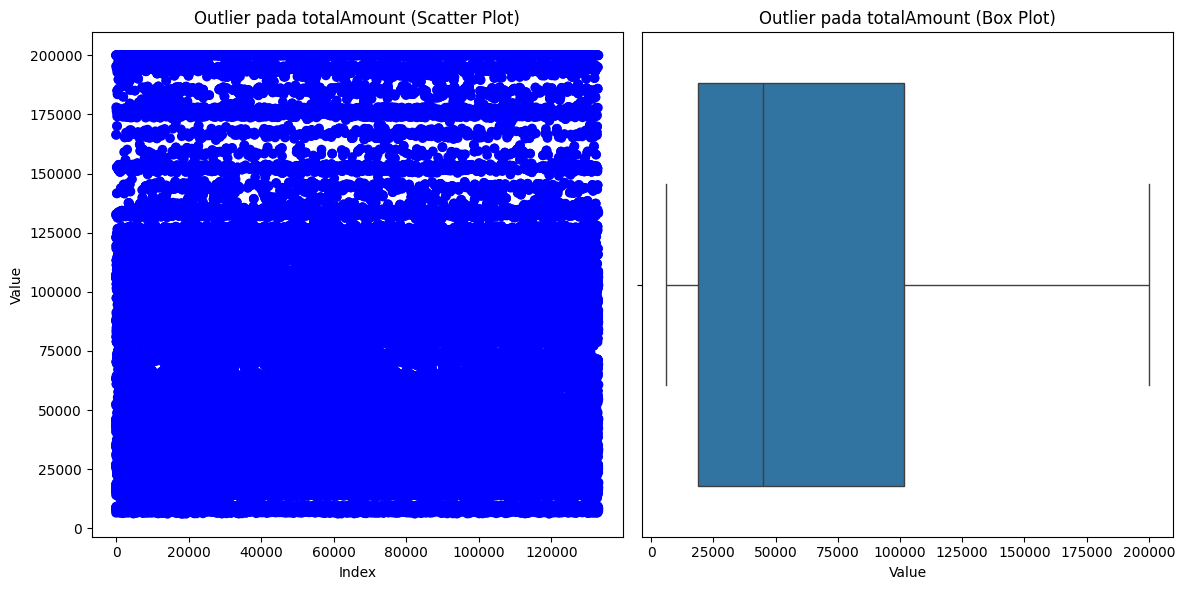

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(range(len(final_df)), final_df['totalAmount'], c=['blue' if not x else 'red' for x in outliers])
ax1.set_title('Outlier pada totalAmount (Scatter Plot)')
ax1.set_xlabel('Index')
ax1.set_ylabel('Value')

sns.boxplot(x=final_df['totalAmount'], ax=ax2)
ax2.set_title('Outlier pada totalAmount (Box Plot)')
ax2.set_xlabel('Value')

plt.tight_layout()
plt.show()

In [19]:
final_df['transactionDate'] = pd.to_datetime(final_df['transactionDate'])

<ipython-input-19-0ea110b0c623>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['transactionDate'] = pd.to_datetime(final_df['transactionDate'])


In [20]:
final_df

,transactionId,invoiceId,customerId,userId,storeId,paymentMethodId,totalAmount,cash,change,discountPerson,...,cityId,districtId,villageId,storeTypeId,postalCode,storeDescription,phoneNumber,logo,permitCertificate,storeStatus
135815,113286,INV-601854327320,1696.0,99,9,2,106560.16,106560.160000,0.000000,0,...,71,5783,63284,10,78915,Reiciendis corrupti fugiat alias distinctio ma...,628110460132,https://dummyimage.com/827x621,https://placekitten.com/802/459,ACTIVE
135816,113287,INV-865460738290,2212.0,122,9,7,41753.64,41824.672669,71.032669,10,...,71,5783,63284,10,78915,Reiciendis corrupti fugiat alias distinctio ma...,628110460132,https://dummyimage.com/827x621,https://placekitten.com/802/459,ACTIVE
135817,113288,INV-122164698029,1918.0,108,9,1,18558.40,18753.472599,195.072599,0,...,71,5783,63284,10,78915,Reiciendis corrupti fugiat alias distinctio ma...,628110460132,https://dummyimage.com/827x621,https://placekitten.com/802/459,ACTIVE
135818,113289,INV-180626689644,3274.0,99,9,6,105847.84,106469.265035,621.425035,0,...,71,5783,63284,10,78915,Reiciendis corrupti fugiat alias distinctio ma...,628110460132,https://dummyimage.com/827x621,https://placekitten.com/802/459,ACTIVE
135819,113290,INV-809534718058,NaN,151,9,7,63169.12,64089.547819,920.427819,0,...,71,5783,63284,10,78915,Reiciendis corrupti fugiat alias distinctio ma...,628110460132,https://dummyimage.com/827x621,https://placekitten.com/802/459,ACTIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268799,224035,INV-944927501334,4565.0,77,9,5,54626.88,55498.976498,872.096498,0,...,71,5783,63284,10,78915,Reiciendis corrupti fugiat alias distinctio ma...,628110460132,https://dummyimage.com/827x621,https://placekitten.com/802/459,ACTIVE
268800,224036,INV-833912557308,2823.0,99,9,1,19325.60,19836.481150,510.881150,0,...,71,5783,63284,10,78915,Reiciendis corrupti fugiat alias distinctio ma...,628110460132,https://dummyimage.com/827x621,https://placekitten.com/802/459,ACTIVE
268801,224037,INV-118795321427,4494.0,122,9,7,46095.84,46199.387895,103.547895,0,...,71,5783,63284,10,78915,Reiciendis corrupti fugiat alias distinctio ma...,628110460132,https://dummyimage.com/827x621,https://placekitten.com/802/459,ACTIVE
268802,224038,INV-335168418523,NaN,80,9,2,83977.00,83977.000000,0.000000,5,...,71,5783,63284,10,78915,Reiciendis corrupti fugiat alias distinctio ma...,628110460132,https://dummyimage.com/827x621,https://placekitten.com/802/459,ACTIVE


## Convert ke Time Series, Feature Engineering, dan Pre-processing

Tahapan ini digunakan untuk mengubah dataset menjadi time series untuk memprediksi data historis, menambahkan fitur berbasis agregasi historis untuk meningkatkan performa model, dan pre-processing data sebelum digunakan untuk melatih model forecasting

In [21]:
time_series = final_df.groupby(final_df['transactionDate'].dt.date)['totalAmount'].sum().reset_index()
time_series.columns = ['date', 'revenue']
time_series['date'] = pd.to_datetime(time_series['date'])
time_series.set_index('date', inplace=True)

In [22]:
time_series

,revenue
date,
2024-01-01,27002666.72
2024-01-02,33468910.44
2024-01-03,33283795.52
2024-01-04,32191587.00
2024-01-05,35836049.72
...,...
2025-04-28,8046936.92
2025-04-29,8846289.64
2025-04-30,6344670.40


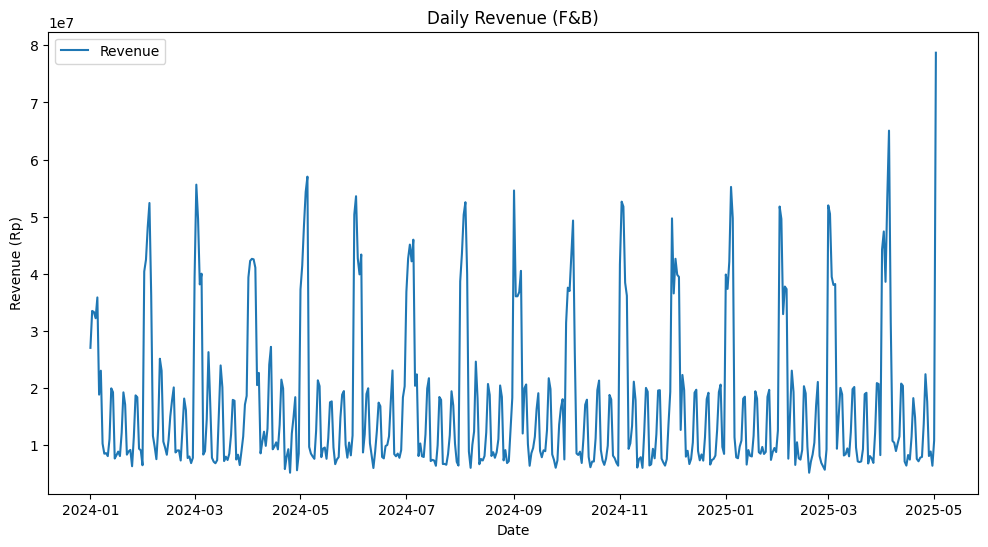

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(time_series['revenue'], label='Revenue')
plt.title('Daily Revenue (F&B)')
plt.xlabel('Date')
plt.ylabel('Revenue (Rp)')
plt.legend()
plt.show()

In [24]:
final_df['transactionDate']

,transactionDate
135815,2024-01-06 08:12:25
135816,2024-01-01 07:53:54
135817,2024-01-02 07:13:17
135818,2024-01-07 07:03:28
135819,2024-01-06 07:00:56
...,...
268799,2025-05-02 18:36:51
268800,2025-05-02 20:31:06
268801,2025-05-02 17:39:28
268802,2025-05-02 19:10:19


<Figure size 1200x400 with 0 Axes>

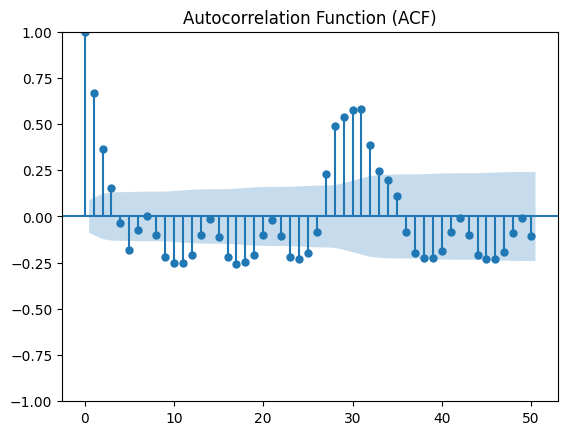

<Figure size 1200x400 with 0 Axes>

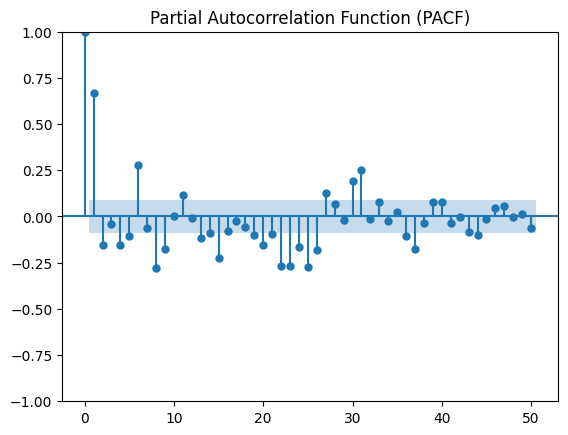

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 4))
plot_acf(time_series['revenue'], lags=50)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plt.figure(figsize=(12, 4))
plot_pacf(time_series['revenue'], lags=50)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [26]:
time_series['rollingAvg7d'] = time_series['revenue'].rolling(window=7, min_periods=1).mean()

id_holidays = holidays.Indonesia(years=[2024, 2025])
time_series['is_holiday'] = time_series.index.isin(id_holidays).astype(int)
time_series['is_payday'] = time_series.index.day.isin([1, 2, 3, 4, 5]).astype(int)
time_series['is_weekend'] = time_series.index.weekday.isin([5, 6]).astype(int)

def create_lag(df, window=7):
    X, y, check_corr = [], [], []
    for i in range(window, len(df)):
        lag_features = df['revenue'].values[i-window:i]
        payday = df['is_payday'].values[i]
        holiday = df['is_holiday'].values[i]
        weekend = df['is_weekend'].values[i]
        rolling_avg_7d = df['rollingAvg7d'].values[i]

        full_feature = list(lag_features) + [payday, holiday, weekend, rolling_avg_7d]
        benchmark = full_feature + [df['revenue'].values[i]]

        X.append(full_feature)
        y.append(df['revenue'].values[i])
        check_corr.append(benchmark)

    return pd.DataFrame(X, columns=[f'lag_{i}' for i in range(window)] + ['is_payday', 'is_holiday', 'is_weekend', 'rollingAvg7d']), \
       pd.Series(y, name='target'), \
       pd.DataFrame(check_corr, columns=[f'lag_{i}' for i in range(window)] + ['is_payday', 'is_holiday', 'is_weekend', 'rollingAvg7d', 'target'])


X, y, check_corr = create_lag(time_series)

<ipython-input-26-1fac8aae5783>:4: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  time_series['is_holiday'] = time_series.index.isin(id_holidays).astype(int)


In [27]:
check_corr

,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,is_payday,is_holiday,is_weekend,rollingAvg7d,target
0,27002666.72,33468910.44,33283795.52,32191587.00,35836049.72,18807071.52,22996172.84,0,0,0,2.668589e+07,10217675.64
1,33468910.44,33283795.52,32191587.00,35836049.72,18807071.52,22996172.84,10217675.64,0,0,0,2.311243e+07,8454654.76
2,33283795.52,32191587.00,35836049.72,18807071.52,22996172.84,10217675.64,8454654.76,0,0,0,1.958014e+07,8557778.48
3,32191587.00,35836049.72,18807071.52,22996172.84,10217675.64,8454654.76,8557778.48,0,0,0,1.612908e+07,8034153.24
4,35836049.72,18807071.52,22996172.84,10217675.64,8454654.76,8557778.48,8034153.24,0,0,0,1.258509e+07,11028110.20
...,...,...,...,...,...,...,...,...,...,...,...,...
476,7543611.76,7127869.28,7763727.88,7895866.36,13657860.96,22382302.48,17559606.40,0,0,0,1.206202e+07,8046936.92
477,7127869.28,7763727.88,7895866.36,13657860.96,22382302.48,17559606.40,8046936.92,0,0,0,1.230751e+07,8846289.64
478,7763727.88,7895866.36,13657860.96,22382302.48,17559606.40,8046936.92,8846289.64,0,0,0,1.210479e+07,6344670.40
479,7895866.36,13657860.96,22382302.48,17559606.40,8046936.92,8846289.64,6344670.40,1,1,0,1.251366e+07,10757972.36


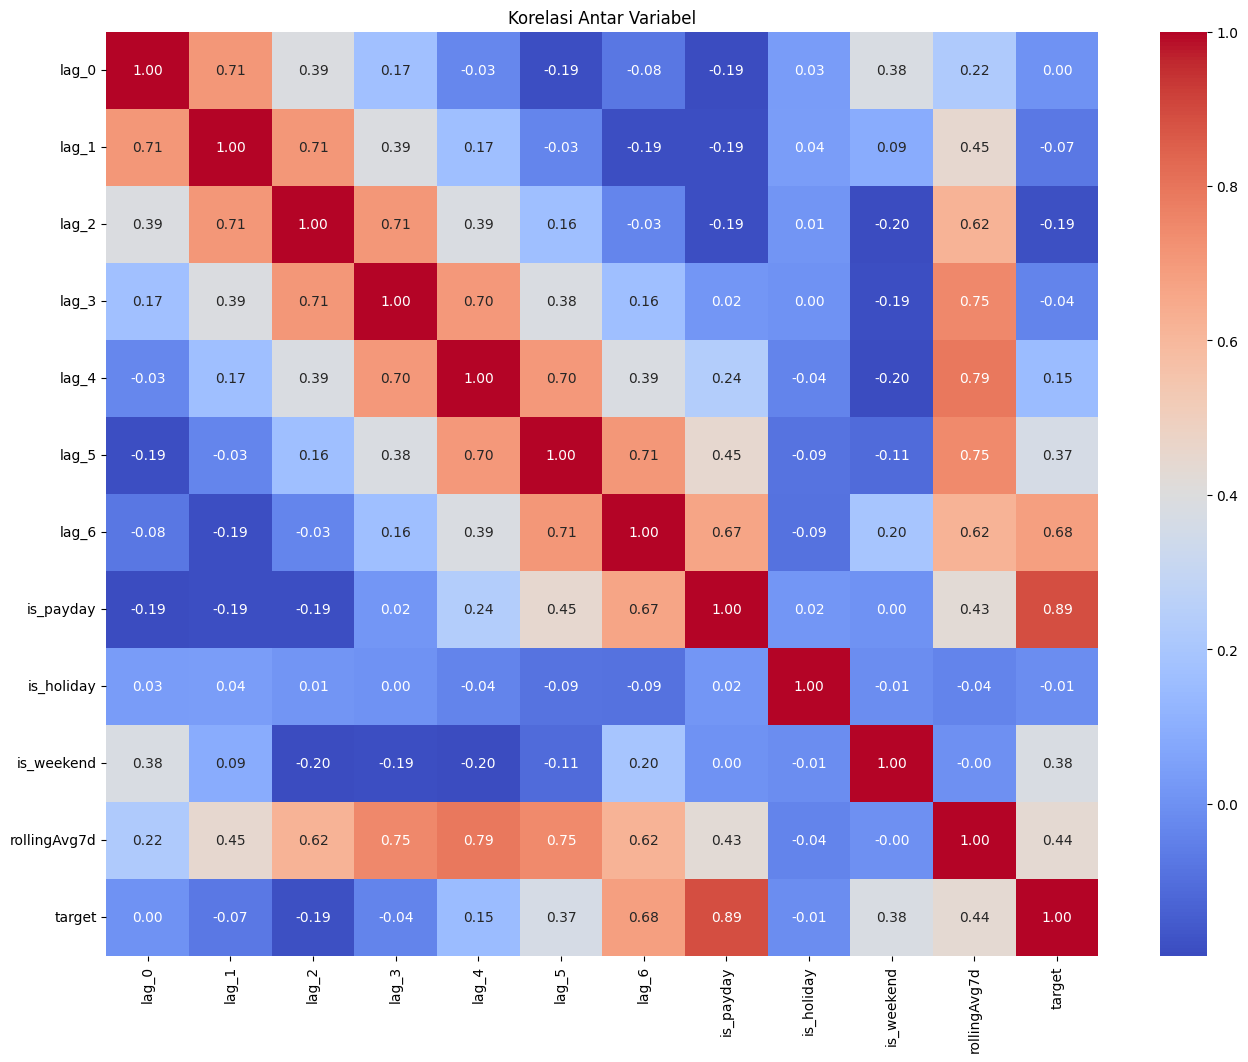

In [28]:
corr_matrix = check_corr.corr()

plt.figure(figsize=(16, 12))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')

plt.title('Korelasi Antar Variabel')

plt.show()

In [29]:
X

,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,is_payday,is_holiday,is_weekend,rollingAvg7d
0,27002666.72,33468910.44,33283795.52,32191587.00,35836049.72,18807071.52,22996172.84,0,0,0,2.668589e+07
1,33468910.44,33283795.52,32191587.00,35836049.72,18807071.52,22996172.84,10217675.64,0,0,0,2.311243e+07
2,33283795.52,32191587.00,35836049.72,18807071.52,22996172.84,10217675.64,8454654.76,0,0,0,1.958014e+07
3,32191587.00,35836049.72,18807071.52,22996172.84,10217675.64,8454654.76,8557778.48,0,0,0,1.612908e+07
4,35836049.72,18807071.52,22996172.84,10217675.64,8454654.76,8557778.48,8034153.24,0,0,0,1.258509e+07
...,...,...,...,...,...,...,...,...,...,...,...
476,7543611.76,7127869.28,7763727.88,7895866.36,13657860.96,22382302.48,17559606.40,0,0,0,1.206202e+07
477,7127869.28,7763727.88,7895866.36,13657860.96,22382302.48,17559606.40,8046936.92,0,0,0,1.230751e+07
478,7763727.88,7895866.36,13657860.96,22382302.48,17559606.40,8046936.92,8846289.64,0,0,0,1.210479e+07
479,7895866.36,13657860.96,22382302.48,17559606.40,8046936.92,8846289.64,6344670.40,1,1,0,1.251366e+07


In [30]:
def save_scalers(scaler_X, scaler_y, store_type_id):
    # Buat direktori untuk tipe toko
    os.makedirs(f'/content/models/store_type_{store_type_id}', exist_ok=True)

    # Simpan scaler_X dan scaler_y
    joblib.dump(scaler_X, f'/content/models/store_type_{store_type_id}/scaler_X.pkl')
    joblib.dump(scaler_y, f'/content/models/store_type_{store_type_id}/scaler_y.pkl')

In [31]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

In [32]:
save_scalers(scaler_X, scaler_y, store_type_id)

In [33]:
train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

## Modeling

In [34]:
def model_builder(hp):
    model = Sequential()

    model.add(Conv1D(
        filters=hp.Int("conv_filters", min_value=32, max_value=128, step=16),
        kernel_size=hp.Int("kernel_size", min_value=2, max_value=5, step=1),
        activation='relu',
        padding='same',
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))

    model.add(MaxPooling1D(pool_size=1))

    model.add(Conv1D(
        filters=hp.Int("conv_filters_2", min_value=64, max_value=256, step=16),
        kernel_size=hp.Int("kernel_size", min_value=2, max_value=5, step=1),
        activation='relu'
    ))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Bidirectional(
        LSTM(
            units=hp.Int("bilstm_units", min_value=16, max_value=128, step=16),
            activation=hp.Choice("lstm_activation", ["relu", "tanh"]),
            return_sequences=True
        )
    ))
    model.add(Dropout(
        rate=hp.Float("dropout_1", min_value=0.2, max_value=0.5, step=0.1)
    ))
    model.add(LSTM(
        units=hp.Int("lstm_units", min_value=16, max_value=64, step=16),
        activation=hp.Choice("lstm2_activation", ["relu", "tanh"]),
        return_sequences=False
    ))
    model.add(Dropout(
        rate=hp.Float("dropout_2", min_value=0.2, max_value=0.5, step=0.1)
    ))

    model.add(Dense(
        units=hp.Int("dense_units", min_value=16, max_value=64, step=16),
        activation=hp.Choice("dense_activation", ["relu", "tanh"])
    ))

    model.add(Dropout(
        rate=hp.Float("dropout_3", min_value=0.2, max_value=0.5, step=0.1)
    ))

    model.add(Dense(
        units=hp.Int("dense_units_2", min_value=32, max_value=128, step=16),
        activation=hp.Choice("dense_activation", ["relu", "tanh"])
    ))

    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[R2Score(), MeanSquaredError(), MeanAbsoluteError()])

    return model

# model = Sequential([
#     Bidirectional(LSTM(32, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))),
#     Dropout(0.2),
#     LSTM(64, activation='relu', return_sequences=False),
#     Dropout(0.2),
#     Dense(32, activation='relu'),
#     Dense(1)
# ])

In [35]:
!rm -rf tuner_dir/

In [36]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, mode='max', start_from_epoch=30, restore_best_weights=True)


tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='lstm_tuning'
)

tuner.search(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stop])

Trial 20 Complete [00h 00m 25s]
val_loss: 0.0029890350997447968

Best val_loss So Far: 0.0005075391381978989
Total elapsed time: 00h 10m 01s


In [37]:
best_hp = tuner.get_best_hyperparameters(1)[0]
print(best_hp.values)
best_model = tuner.hypermodel.build(best_hp)

{'conv_filters': 112, 'kernel_size': 3, 'conv_filters_2': 96, 'bilstm_units': 48, 'lstm_activation': 'tanh', 'dropout_1': 0.4, 'lstm_units': 64, 'lstm2_activation': 'tanh', 'dropout_2': 0.4, 'dense_units': 64, 'dense_activation': 'tanh', 'dropout_3': 0.2, 'dense_units_2': 112}


In [38]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_r2_score', patience=1, restore_best_weights=True)

In [39]:
history = best_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    # callbacks=[early_stopping]
)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - loss: 0.0440 - mean_absolute_error: 0.1487 - mean_squared_error: 0.0440 - r2_score: -0.4084 - val_loss: 0.0189 - val_mean_absolute_error: 0.1004 - val_mean_squared_error: 0.0189 - val_r2_score: 0.3103
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0176 - mean_absolute_error: 0.0991 - mean_squared_error: 0.0176 - r2_score: 0.3618 - val_loss: 0.0096 - val_mean_absolute_error: 0.0679 - val_mean_squared_error: 0.0096 - val_r2_score: 0.6513
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0134 - mean_absolute_error: 0.0824 - mean_squared_error: 0.0134 - r2_score: 0.5299 - val_loss: 0.0060 - val_mean_absolute_error: 0.0447 - val_mean_squared_error: 0.0060 - val_r2_score: 0.7814
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0100 - mean_absolute_error: 0.0671 - mean_squared_error: 0.0100 - r2_score: 0.7269 - val_loss: 0.0042 - val_mean_absolute_error: 0.0473 - val_mean_squared_error: 0.0042 - va

In [40]:
y_pred_scaled = best_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled).ravel()
y_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


In [41]:
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
r2 = r2_score(y_actual, y_pred)

In [42]:
print(f"LSTM: MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.2f}")

LSTM: MAE=2744653.89, RMSE=5801890.06, R2=0.85


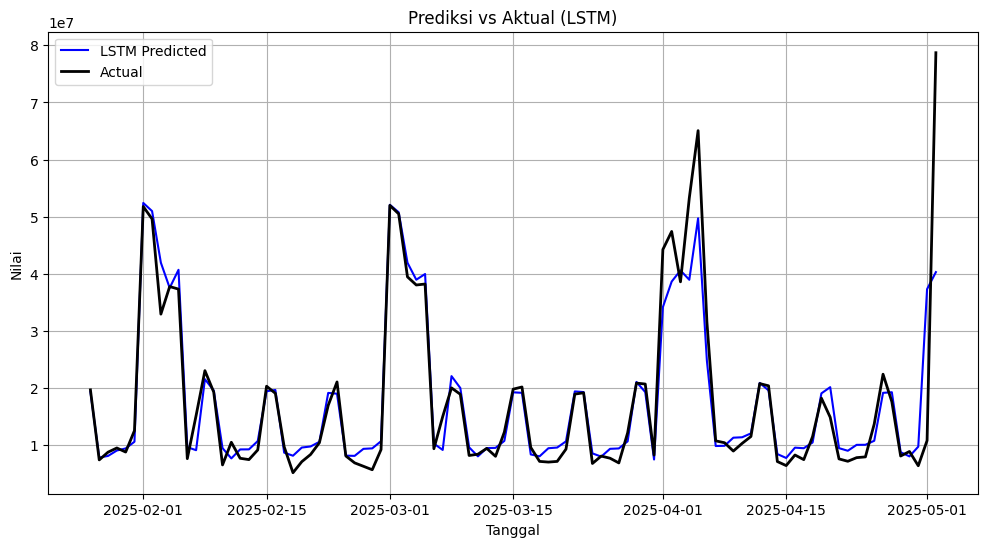

In [43]:
last_dates = time_series.index[-len(y_test):]
plt.figure(figsize=(12, 6))
plt.plot(last_dates, y_pred, label='LSTM Predicted', color='blue')
plt.plot(last_dates, y_actual, label='Actual', color='black', linewidth=2)
plt.title('Prediksi vs Aktual (LSTM)')
plt.xlabel('Tanggal')
plt.ylabel('Nilai')
plt.legend()
plt.grid()
plt.show()

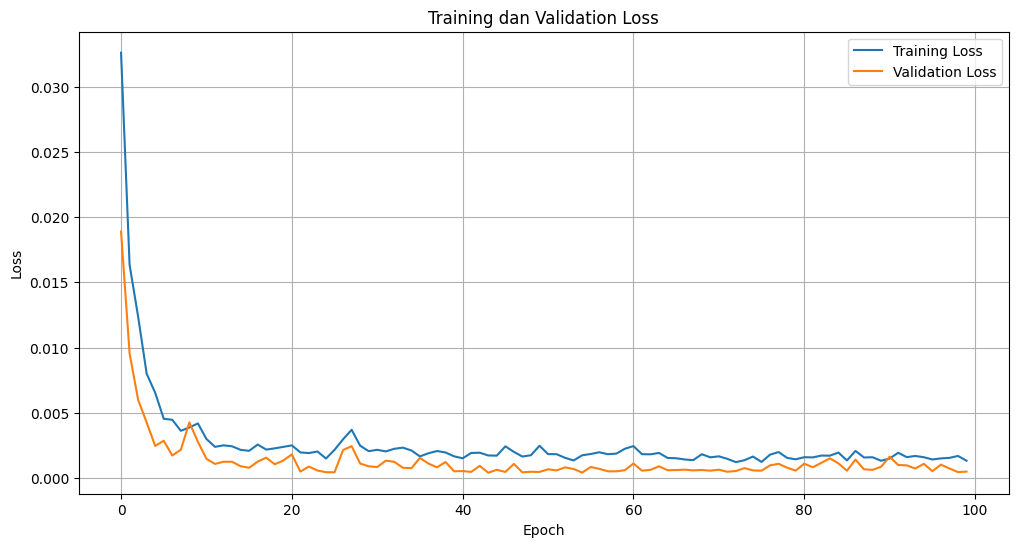

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training dan Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

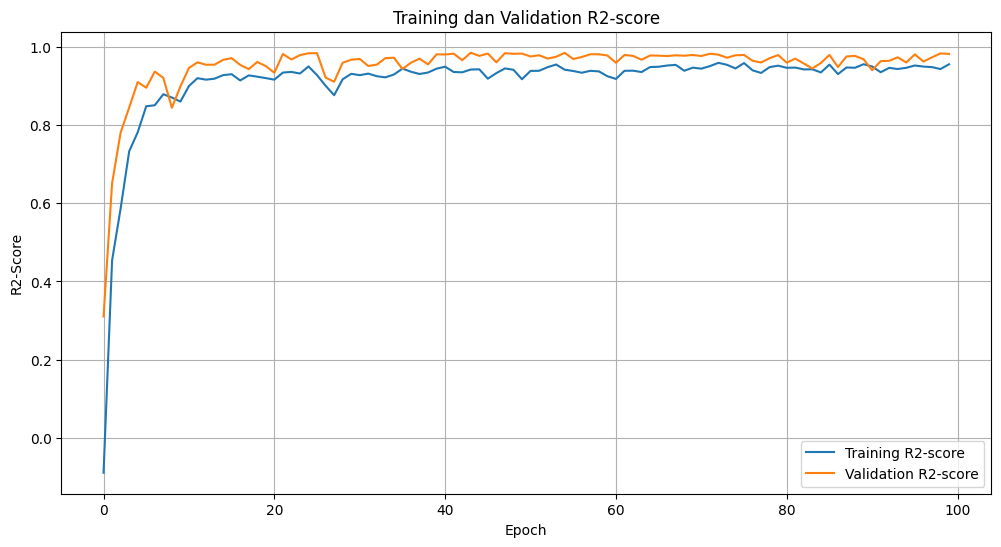

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['r2_score'], label='Training R2-score')
plt.plot(history.history['val_r2_score'], label='Validation R2-score')
plt.title('Training dan Validation R2-score')
plt.xlabel('Epoch')
plt.ylabel('R2-Score')
plt.legend()
plt.grid()
plt.show()

In [46]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
import holidays
import matplotlib.pyplot as plt

def prepare_inference_data(time_series, window=7, scaler_X=None):
    """
    Prepare the latest data for inference by creating lag features and scaling.

    Parameters:
    - time_series: DataFrame with columns ['revenue', 'rollingAvg7d', 'is_holiday', 'is_payday', 'is_weekend']
    - window: Number of lag days (default=7)
    - scaler_X: Fitted MinMaxScaler for features

    Returns:
    - X_scaled: Scaled input features for prediction
    - last_index: Index of the last data point
    """
    # Validate required columns
    required_columns = ['revenue', 'rollingAvg7d', 'is_holiday', 'is_payday', 'is_weekend']
    if not all(col in time_series.columns for col in required_columns):
        raise ValueError("Time series missing required columns")

    # Get the last window+1 rows
    df = time_series.tail(window + 1).copy()

    # Extract features for the last data point
    lag_features = df['revenue'].values[-window:]
    payday = df['is_payday'].values[-1]
    holiday = df['is_holiday'].values[-1]
    weekend = df['is_weekend'].values[-1]
    rolling_avg_7d = df['rollingAvg7d'].values[-1]

    # Combine features
    full_feature = list(lag_features) + [payday, holiday, weekend, rolling_avg_7d]

    # Create DataFrame for features
    X = pd.DataFrame([full_feature], columns=[f'lag_{i}' for i in range(window)] +
                     ['is_payday', 'is_holiday', 'is_weekend', 'rollingAvg7d'])

    # Scale features
    X_scaled = scaler_X.transform(X)
    X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

    return X_scaled, df.index[-1]

def predict_next_day(model, time_series, window=7, scaler_X=None, scaler_y=None):
    """
    Predict the revenue for the next day using the trained model.

    Parameters:
    - model: Trained Keras model
    - time_series: DataFrame with historical data
    - window: Number of lag days (default=7)
    - scaler_X: Fitted MinMaxScaler for features
    - scaler_y: Fitted MinMaxScaler for target

    Returns:
    - prediction: Predicted revenue (unscaled)
    - prediction_date: Date of the prediction
    """
    # Prepare data
    X_scaled, last_index = prepare_inference_data(time_series, window, scaler_X)

    # Make prediction
    y_pred_scaled = model.predict(X_scaled, verbose=0)

    # Inverse transform
    y_pred = scaler_y.inverse_transform(y_pred_scaled).ravel()[0]

    # Calculate next day's date
    prediction_date = last_index + pd.Timedelta(days=1)

    return y_pred, prediction_date

def update_time_series_for_next_day(time_series, predicted_revenue, next_date, id_holidays):
    """
    Update time_series with the predicted revenue and new features.

    Parameters:
    - time_series: Original DataFrame
    - predicted_revenue: Predicted revenue
    - next_date: Date for the prediction
    - id_holidays: holidays.Indonesia object

    Returns:
    - Updated time_series
    """
    # Create new row
    new_row = pd.DataFrame({
        'revenue': [predicted_revenue],
        'is_holiday': [int(next_date in id_holidays)],
        'is_payday': [int(next_date.day in [1, 2, 3, 4, 5])],
        'is_weekend': [int(next_date.weekday() in [5, 6])]
    }, index=[next_date])

    # Append new row
    time_series = pd.concat([time_series, new_row])

    # Update rolling average
    time_series['rollingAvg7d'] = time_series['revenue'].rolling(window=7, min_periods=1).mean()

    return time_series

def predict_7_days(model, time_series, window=7, scaler_X=None, scaler_y=None, id_holidays=None):
    """
    Predict revenue for the next 7 days and update time_series iteratively.

    Parameters:
    - model: Trained Keras model
    - time_series: DataFrame with historical data
    - window: Number of lag days (default=7)
    - scaler_X: Fitted MinMaxScaler for features
    - scaler_y: Fitted MinMaxScaler for target
    - id_holidays: holidays.Indonesia object

    Returns:
    - predictions: DataFrame with dates and predicted revenues
    - updated_time_series: Updated time_series with predictions
    """
    predictions = []
    updated_time_series = time_series.copy()

    for _ in range(7):
        # Predict next day
        pred_revenue, pred_date = predict_next_day(
            model=model,
            time_series=updated_time_series,
            window=window,
            scaler_X=scaler_X,
            scaler_y=scaler_y
        )

        # Store prediction
        predictions.append({'date': pred_date, 'revenue': pred_revenue})

        # Update time_series
        updated_time_series = update_time_series_for_next_day(
            time_series=updated_time_series,
            predicted_revenue=pred_revenue,
            next_date=pred_date,
            id_holidays=id_holidays
        )

    # Convert predictions to DataFrame
    predictions_df = pd.DataFrame(predictions)
    predictions_df['date'] = pd.to_datetime(predictions_df['date'])
    predictions_df.set_index('date', inplace=True)

    return predictions_df, updated_time_series

# Example usage
# Prerequisites:
# - best_model: Trained Keras model
# - time_series: DataFrame with historical data
# - scaler_X: Fitted MinMaxScaler for features
# - scaler_y: Fitted MinMaxScaler for target
# - id_holidays: holidays.Indonesia(years=[2024, 2025])

# Predict 7 days
predictions_df, time_series_updated = predict_7_days(
    model=best_model,
    time_series=time_series,
    window=7,
    scaler_X=scaler_X,
    scaler_y=scaler_y,
    id_holidays=id_holidays
)

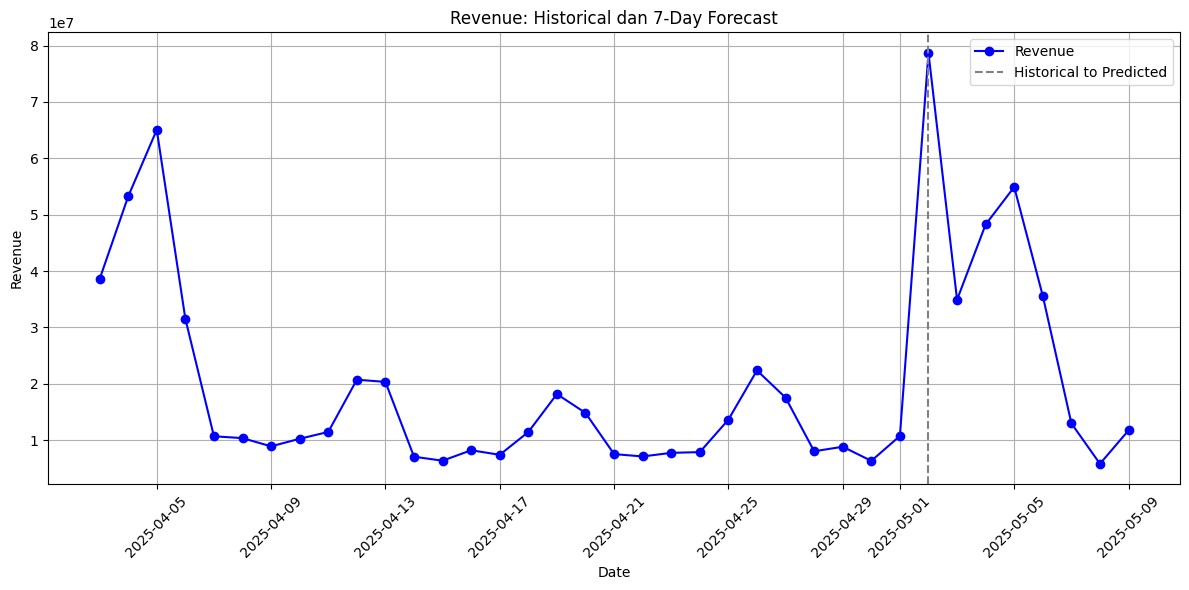

In [47]:
# Combine historical and predicted data for plotting
historical_data = time_series.tail(30)  # Last 30 days of historical data
combined_data = pd.concat([historical_data['revenue'], predictions_df['revenue']])

# Visualize historical and predicted revenue with smooth transition
plt.figure(figsize=(12, 6))
plt.plot(combined_data.index, combined_data.values, label='Revenue', color='blue', marker='o')

# Highlight the transition with a vertical line (optional)
last_historical_date = historical_data.index[-1]

plt.axvline(x=last_historical_date, color='gray', linestyle='--', label='Historical to Predicted')
plt.title('Revenue: Historical dan 7-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [48]:
# Display predictions and updated time_series
print("Predicted revenue for the next 7 days:")
print(predictions_df)
print("\nUpdated time_series tail:")
print(time_series_updated.tail(7))

Predicted revenue for the next 7 days:
               revenue
date                  
2025-05-03  34924848.0
2025-05-04  48274232.0
2025-05-05  54920032.0
2025-05-06  35589452.0
2025-05-07  12998153.0
2025-05-08   5823420.5
2025-05-09  11758330.0

Updated time_series tail:
               revenue  rollingAvg7d  is_holiday  is_payday  is_weekend
2025-05-03  34924848.0  2.359861e+07           0          1           1
2025-05-04  48274232.0  2.798641e+07           0          1           1
2025-05-05  54920032.0  3.468257e+07           0          1           0
2025-05-06  35589452.0  3.850302e+07           0          0           0
2025-05-07  12998153.0  3.945352e+07           0          0           0
2025-05-08   5823420.5  3.874858e+07           0          0           0
2025-05-09  11758330.0  2.918407e+07           0          0           0


In [49]:
best_model.save(f'model_{store_type_id}.keras')